In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')
# Import the numpy and pandas package

import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Predefined functions which we will use further

In [3]:

def accu_sensi_spec(df,Target_col,Target_prob_col):
    # Let's create columns with different probability cutoffs 
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i]= df[Target_prob_col].map(lambda x: 1 if x > i else 0)
    # y_train_pred_final.head()
    
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix
    
    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives
    
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(df[Target_col], df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    
    
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

#FOR ROC CURVE
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


#precision_recall_curve
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def draw_precision_recall(actual, probs):
    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(actual, probs)
    
    # Calculate AUC for the Precision-Recall curve
    pr_auc = auc(recall, precision)
    
    # Plot the Precision-Recall curve
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label='PR curve (AUC = %0.2f)' % pr_auc)
    #plt.plot([1, 0], [1, 0], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

# Usage example:
# draw_precision_recall(actual=y_true, probs=y_pred_proba)


In [4]:
# store the data in dataframe
df=pd.read_csv("Lead_data_clean.csv")
df_new=df
df_new.head()

,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,0,0.0,0,0.0,Website Activity,0,Modified
1,API,Organic Search,0,5.0,674,2.5,Email Activity,0,Email Activity
2,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Activity,1,Email Activity
3,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Unreachable,0,Modified
4,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,0,Modified


# Dummies variable Creation

In [6]:
# Creating dummy variables for the variable 'Quick Add Form '
d1 = pd.get_dummies(df_new['Lead Origin'], prefix='Lead Origin').astype(int)
# Dropping Quick Add Form colum
d1 = d1.drop(['Lead Origin_Lead Import'], axis=1)
#Adding the results to the master dataframe

df_new = pd.concat([df_new,d1], axis=1)

# Creating dummy variables for the variable 'Lead Source'
d2 = pd.get_dummies(df_new['Lead Source'], prefix='Lead Source').astype(int)
# Dropping Other
d2 = d2.drop(['Lead Source_Other'], axis=1)
#Adding the results to the master dataframe
df_new = pd.concat([df_new,d2], axis=1)

# Creating dummy variables for the variable 'Last Activity'
d3 = pd.get_dummies(df_new['Last Activity'], prefix='Last Activity').astype(int)
# Dropping Unreachable
d3 = d3.drop(['Last Activity_Unreachable'], axis=1)
#Adding the results to the master dataframe
df_new = pd.concat([df_new,d3], axis=1)

# Creating dummy variables for the variable 'Last Notable Activity'
d4 = pd.get_dummies(df_new['Last Notable Activity'], prefix='Last Notable Activity').astype(int)
# Dropping Others
d4 = d4.drop(['Last Notable Activity_Others'], axis=1)
#Adding the results to the master dataframe
df_new = pd.concat([df_new,d4], axis=1)

In [7]:
cols=['Lead Origin','Lead Source','Last Activity','Last Notable Activity']
df_new.drop(columns=cols, inplace=True,axis=1)
df_new.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,...,Lead Source_Reference,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Direct Communication,Last Activity_Email Activity,Last Activity_Website Activity,Last Notable Activity_Direct Communication,Last Notable Activity_Email Activity,Last Notable Activity_Modified,Last Notable Activity_Website Activity
0,0,0.0,0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,5.0,674,2.5,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,2.0,1532,2.0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,1.0,305,1.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2.0,1428,1.0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0


# Standarising Numerical variables and do Train-Test Split

In [9]:
cat_cols=[]
num_cols=[]
for i in df_new.columns:
    if df_new[i].nunique()>2:
        num_cols.append(i)
        
    else:
        cat_cols.append(i)

df_new[num_cols]

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
0,0.0,0,0.00
1,5.0,674,2.50
2,2.0,1532,2.00
3,1.0,305,1.00
4,2.0,1428,1.00
...,...,...,...
8508,8.0,1845,2.67
8509,2.0,238,2.00
8510,2.0,199,2.00
8511,3.0,499,3.00


In [10]:
df_train,df_test=train_test_split(df_new,train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(5959, 22)
(2554, 22)


In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scalar=StandardScaler()

df_train[num_cols]=scalar.fit_transform(df_train[num_cols])

df_train[num_cols].head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
4712,-1.153092,-0.867873,-1.253080
5808,-0.743258,0.108309,-0.648118
3331,1.305912,-0.842280,0.561805
2736,0.896078,-0.451076,0.259325
7482,-0.743258,-0.767330,-0.648118


In [13]:
df_test[num_cols]=scalar.transform(df_test[num_cols])

df_test[num_cols].head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
6772,0.486244,-0.191492,1.166767
7723,3.355082,2.528656,2.074210
3170,1.305912,-0.584524,2.376691
7978,0.076410,0.671351,-0.345637
7408,0.076410,1.477524,0.561805


# Logistic Regression Starts

In [15]:
y_train=df_train['Converted']
X_train=df_train.drop(['Converted'],axis=1)

print(X_train.head(), '\n')
y_test=df_test['Converted']
X_test=df_test.drop(['Converted'],axis=1)

print(X_test.head())

      TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
4712    -1.153092                    -0.867873             -1.253080   
5808    -0.743258                     0.108309             -0.648118   
3331     1.305912                    -0.842280              0.561805   
2736     0.896078                    -0.451076              0.259325   
7482    -0.743258                    -0.767330             -0.648118   

      A free copy of Mastering The Interview  Lead Origin_API  \
4712                                       0                1   
5808                                       0                1   
3331                                       0                0   
2736                                       0                0   
7482                                       1                0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
4712                                    0                          0   
5808                            

## RFE

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg=LogisticRegression()
# Initialize the RFE with the estimator (logreg) and the number of features to select (15)
rfe=RFE(logreg,n_features_to_select=15)

rfe=rfe.fit(X_train,y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 2),
 ('A free copy of Mastering The Interview', False, 7),
 ('Lead Origin_API', True, 1),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', False, 5),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 4),
 ('Lead Source_Reference', False, 3),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Converted to Lead', True, 1),
 ('Last Activity_Direct Communication', False, 6),
 ('Last Activity_Email Activity', True, 1),
 ('Last Activity_Website Activity', True, 1),
 ('Last Notable Activity_Direct Communication', True, 1),
 ('Last Notable Activity_Email Activity', True, 1),
 ('Last Notable Activity_Modified', True, 1),
 ('Last Notable Activity_Website Activity', True, 1)]

In [18]:
col = X_train.columns[rfe.support_]
X_train[col]

,TotalVisits,Total Time Spent on Website,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Olark Chat,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Activity,Last Activity_Website Activity,Last Notable Activity_Direct Communication,Last Notable Activity_Email Activity,Last Notable Activity_Modified,Last Notable Activity_Website Activity
4712,-1.153092,-0.867873,1,0,0,0,1,0,0,1,0,0,0,1,0
5808,-0.743258,0.108309,1,0,0,0,0,0,1,0,0,0,0,1,0
3331,1.305912,-0.842280,0,1,0,0,0,0,0,0,1,0,0,1,0
2736,0.896078,-0.451076,0,1,0,0,0,0,0,1,0,0,0,1,0
7482,-0.743258,-0.767330,0,1,0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,-1.153092,-0.867873,1,0,0,0,1,0,0,1,0,0,0,1,0
79,-0.333424,1.115569,0,1,0,0,0,0,1,0,0,0,0,1,0
8039,1.305912,-0.275583,0,1,0,1,0,0,0,1,0,0,1,0,0
6936,-0.333424,-0.103745,0,1,0,0,0,0,0,1,0,0,0,1,0


In [19]:
# Adding constant
X_train_sm=sm.add_constant(X_train[col],has_constant='add')
X_test_sm=sm.add_constant(X_test[col],has_constant='add')

#### While dropping variables, we are following the standard process of evaluating p-values and VIFs (Variance Inflation Factors) to decide which variables to remove. However, instead of dropping variables one by one manually, we have combined this process into a single block of code to make it more efficient and concise. This approach helps streamline the process while achieving the same result.

### Model 1

In [22]:
model1=sm.GLM(np.array(y_train),X_train_sm,family=sm.families.Binomial())
res1=model1.fit()
print(res1.summary(),'\n')

vif=pd.DataFrame()
vif['Feature']=X_train_sm.columns
vif['VIF']=[variance_inflation_factor(X_train_sm.values,i) for i in range(X_train_sm.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF", ascending=False)
print(vif)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5959
Model:                            GLM   Df Residuals:                     5943
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2756.6
Date:                Tue, 19 Nov 2024   Deviance:                       5513.1
Time:                        07:44:14   Pearson chi2:                 6.12e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3304
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### model 2

In [24]:

X_train_sm2=X_train_sm.drop(["Last Notable Activity_Direct Communication","Last Activity_Website Activity"],axis=1)
X_test_sm2=X_test_sm.drop(["Last Notable Activity_Direct Communication","Last Activity_Website Activity"],axis=1)

model2=sm.GLM(np.array(y_train),X_train_sm2,family=sm.families.Binomial())
res2=model2.fit()
print(res2.summary(),'\n')

vif=pd.DataFrame()
vif['Feature']=X_train_sm2.columns
vif['VIF']=[variance_inflation_factor(X_train_sm2.values,i) for i in range(X_train_sm2.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF", ascending=False)
print(vif)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5959
Model:                            GLM   Df Residuals:                     5945
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2757.2
Date:                Tue, 19 Nov 2024   Deviance:                       5514.4
Time:                        07:44:14   Pearson chi2:                 6.12e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3302
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### Model 3

In [26]:
X_train_sm3=X_train_sm2.drop(["Last Activity_Converted to Lead","Lead Source_Welingak Website"],axis=1)
X_test_sm3=X_test_sm2.drop(["Last Activity_Converted to Lead","Lead Source_Welingak Website"],axis=1)

model3=sm.GLM(np.array(y_train),X_train_sm3,family=sm.families.Binomial())
res3=model3.fit()
print(res3.summary(),'\n')

vif=pd.DataFrame()
vif['Feature']=X_train_sm3.columns
vif['VIF']=[variance_inflation_factor(X_train_sm3.values,i) for i in range(X_train_sm3.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF", ascending=False)
print(vif)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5959
Model:                            GLM   Df Residuals:                     5947
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2762.7
Date:                Tue, 19 Nov 2024   Deviance:                       5525.3
Time:                        07:44:14   Pearson chi2:                 6.24e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3290
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### model 4

In [28]:

X_train_sm4=X_train_sm3.drop(["Lead Origin_Landing Page Submission","Lead Origin_API"],axis=1)
X_test_sm4=X_test_sm3.drop(["Lead Origin_Landing Page Submission","Lead Origin_API"],axis=1)

model4=sm.GLM(np.array(y_train),X_train_sm4,family=sm.families.Binomial())
res4=model4.fit()
print(res4.summary(),'\n')

vif=pd.DataFrame()
vif['Feature']=X_train_sm4.columns
vif['VIF']=[variance_inflation_factor(X_train_sm4.values,i) for i in range(X_train_sm4.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF", ascending=False)
print(vif)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5959
Model:                            GLM   Df Residuals:                     5949
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2766.9
Date:                Tue, 19 Nov 2024   Deviance:                       5533.8
Time:                        07:44:15   Pearson chi2:                 6.25e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3281
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

## Finalizing Model 4

In [30]:
# Getting the predicted values on the train set
y_train_pred=res4.predict(X_train_sm4)

y_train_pred = y_train_pred.values.reshape(-1) 

# Display the first few results
print(y_train_pred[:10])

[0.14805933 0.1289902  0.07010177 0.13204953 0.04246063 0.24968416
 0.83614376 0.6606769  0.14805933 0.9194756 ]


In [31]:
#Creating dataframe y_train_pred_final
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})

y_train_pred_final.head()

,Converted,Converted_Prob
0,0,0.148059
1,0,0.128990
2,0,0.070102
3,0,0.132050
4,0,0.042461


In [32]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_Prob,predicted
0,0,0.148059,0
1,0,0.128990,0
2,0,0.070102,0
3,0,0.132050,0
4,0,0.042461,0


### Model Evalution on Train dataset

In [34]:
from sklearn import metrics
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3294  412]
 [ 892 1361]]


In [35]:
# Print the accuracy
accuracy = metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
print(f"Accuracy: {accuracy}")

# Print the classification report
classification_report = metrics.classification_report(y_train_pred_final.Converted, y_train_pred_final.predicted)
print("Classification Report:\n", classification_report)

Accuracy: 0.7811713374727304
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.83      3706
           1       0.77      0.60      0.68      2253

    accuracy                           0.78      5959
   macro avg       0.78      0.75      0.76      5959
weighted avg       0.78      0.78      0.77      5959



     prob  accuracy     sensi     speci
0.0   0.0  0.378084  1.000000  0.000000
0.1   0.1  0.495721  0.977364  0.202914
0.2   0.2  0.710690  0.905903  0.592013
0.3   0.3  0.772109  0.821127  0.742310
0.4   0.4  0.783521  0.742565  0.808419
0.5   0.5  0.781171  0.604083  0.888829
0.6   0.6  0.770935  0.523302  0.921479
0.7   0.7  0.755664  0.437195  0.949271
0.8   0.8  0.731499  0.338660  0.970318
0.9   0.9  0.684343  0.186418  0.987048


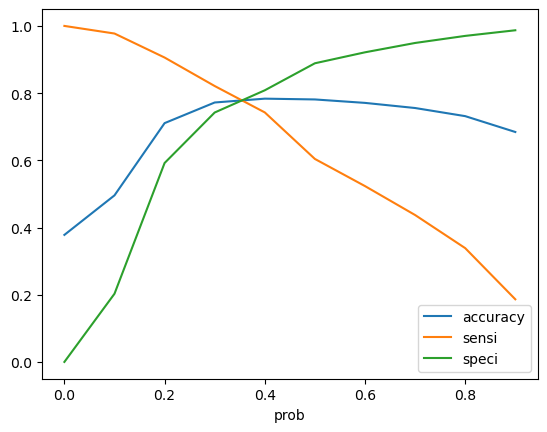

In [36]:
accu_sensi_spec(y_train_pred_final,"Converted","Converted_Prob")

In [37]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.38 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.148059,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.128990,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.070102,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.132050,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.042461,0,1,0,0,0,0,0,0,0,0,0,0


In [38]:
# Print the accuracy
accuracy = metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
print(f"Accuracy: {accuracy}")

# Print the classification report
classification_report = metrics.classification_report(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
print("Classification Report:\n", classification_report)

Accuracy: 0.7798288303406612
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      3706
           1       0.69      0.75      0.72      2253

    accuracy                           0.78      5959
   macro avg       0.77      0.77      0.77      5959
weighted avg       0.78      0.78      0.78      5959



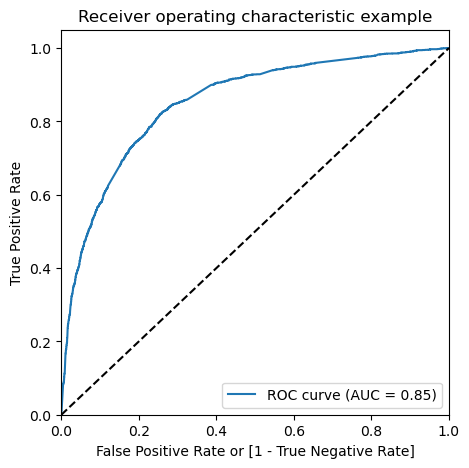

In [39]:
draw_roc(y_train_pred_final.Converted,y_train_pred_final.Converted_Prob)

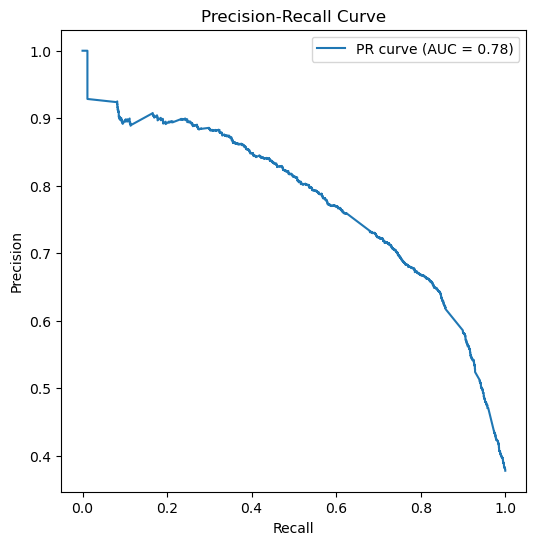

In [40]:
draw_precision_recall(y_train_pred_final.Converted,y_train_pred_final.Converted_Prob)

## Now applying on Test data-set

In [42]:
y_test_pred=res4.predict(X_test_sm4)
y_test_pred=y_test_pred.values.reshape(-1)
y_test_pred

array([0.11732798, 0.83012851, 0.18360907, ..., 0.52333259, 0.51632236,
       0.06663011])

In [43]:
#Creating Dataframe y_test_pred_final
y_test_pred_final=pd.DataFrame({'Converted':y_test.values, 'Converted_Prob':y_test_pred})
y_test_pred_final.head()

,Converted,Converted_Prob
0,0,0.117328
1,0,0.830129
2,0,0.183609
3,1,0.359232
4,1,0.852191


In [44]:
y_test_pred_final['final_predicted']=y_test_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.38 else 0)
y_test_pred_final.head()

,Converted,Converted_Prob,final_predicted
0,0,0.117328,0
1,0,0.830129,1
2,0,0.183609,0
3,1,0.359232,0
4,1,0.852191,1


### Model Evalution on Test dataset

In [46]:
# Print the classification report
classification_report = metrics.classification_report(y_test_pred_final.Converted, y_test_pred_final.final_predicted)
print("Classification Report:\n", classification_report)


# Print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.final_predicted)
print("Confusion Matrix:\n", confusion_matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      1601
           1       0.69      0.77      0.73       953

    accuracy                           0.79      2554
   macro avg       0.77      0.78      0.78      2554
weighted avg       0.79      0.79      0.79      2554

Confusion Matrix:
 [[1278  323]
 [ 222  731]]


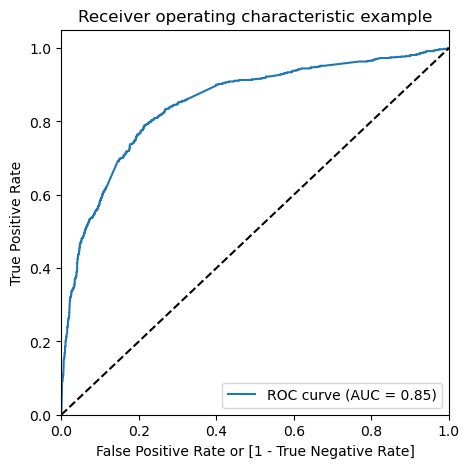

In [47]:
draw_roc(y_test_pred_final.Converted,y_test_pred_final.Converted_Prob)

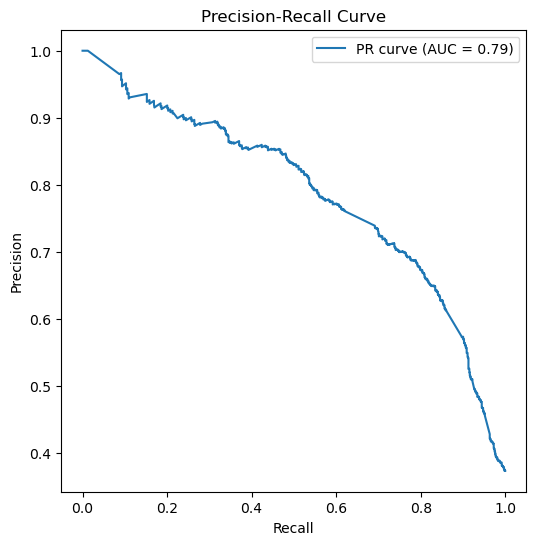

In [48]:
draw_precision_recall(y_test_pred_final.Converted,y_test_pred_final.Converted_Prob)

### Creating Lead_Score column to prioritize the leads

In [50]:
# Scale the Converted_Prob column to a range of 0 to 100 and round to 2 decimals
y_test_pred_final['Lead_Score'] = (y_test_pred_final['Converted_Prob'] * 100).round(2)

# Preview the updated DataFrame
y_test_pred_final.head()



,Converted,Converted_Prob,final_predicted,Lead_Score
0,0,0.117328,0,11.73
1,0,0.830129,1,83.01
2,0,0.183609,0,18.36
3,1,0.359232,0,35.92
4,1,0.852191,1,85.22


# Precision Recall

The Precision-Recall Curve is a key evaluation metric for classification tasks, particularly when dealing with imbalanced datasets. 
Here's why we use the Precision-Recall Curve:

The Precision-Recall Curve is crucial for evaluating models on imbalanced datasets, focusing on the positive class. It highlights the trade-off between Precision (accuracy of positive predictions) and Recall (coverage of actual positives), making it ideal for lead conversion tasks. This curve helps select the optimal threshold for balancing accurate lead targeting (high precision) and capturing more potential leads (high recall). Unlike the ROC curve, it emphasizes the positive class, ensuring better decision-making for resource optimization and conversion strategies.